In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import os 
import cv2
from datetime import datetime
import keras
import random
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D,Bidirectional
from keras.layers import AveragePooling2D, Flatten, Activation
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add,concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
test_data=pd.read_csv('sampled_data_100.csv') 

In [3]:
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)
print(test_data.shape)

(100, 2)


In [4]:
def preprocess(test_img):
    test_img_resized=cv2.resize(test_img,(170,32))
    test_image=test_img_resized[:,:,1]
    test_image=test_image.T 
    test_image=np.expand_dims(test_image,axis=-1)
    test_image=np.expand_dims(test_image, axis=0)
    test_image=test_image/255
    return test_image

In [5]:
test_data.head()

,ImageName,Labels
0,Test_data/1_BASEMAN.jpg,BASEMAN
1,Test_data/2_DIRECTS.jpg,DIRECTS
2,Test_data/3_lidless.jpg,LIDLESS
3,Test_data/4_riposte.jpg,RIPOSTE
4,Test_data/5_Smudges.jpg,SMUDGES


In [6]:
letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [7]:
def words_from_labels(labels):
    txt=[]
    for ele in labels:
        if ele == len(letters): 
            txt.append("")
        else:
            txt.append(letters[ele])
    return "".join(txt)

In [8]:
def decode_label(out):
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  

    outstr=words_from_labels(out_best)
    return outstr

In [9]:
img_h=32
img_w=170
img_c=1
num_classes=len(letters)+1
batch_size=64
max_length=15

In [10]:
def model_create(drop_out_rate=0.35):
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    return Model(inputs=[model_input], outputs=y_pred)

In [11]:
def test_data_single_image_Prediction(model,test_img_path):
    start=datetime.now()
    test_img=cv2.imread(test_img_path)
    test_image=preprocess(test_img)
    model_output=model.predict(test_image)
    predicted_output=decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ",datetime.now()-start)    

In [12]:
def test_data_multiple_image_Prediction(model,test_img_names,test_labels,total):
    start=datetime.now()
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    for i in range(len(test_labels)):
        test_img=cv2.imread(test_img_names[i])
        test_image=preprocess(test_img)
        model_output=model.predict(test_image)
        predicted_output=decode_label(model_output)
        actual_output=test_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
        print("-"*80)
        print("Actual Text: ",actual_output,"   Predicted Text: ",predicted_output)
    print("="*80)
    print("Model Output Accuracy: ",(accuracy/total)*100, " %")
    print("Model Output Letter Accuracy: ",(letter_acc/letter_cnt)*100, " %")
    print("Time Taken for Processing: ",datetime.now()-start)

In [13]:
model=model_create()

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 170, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 170, 32, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 170, 32, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 170, 32, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 85, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 85, 16, 128)       73856     
                                                             

In [15]:
model.load_weights('Best_Img_recog_LSTM_Adam_model_run_weights.h5')

In [ ]:
print(xyz)

In [17]:
test_image_0='Test_data/3_lidless.jpg'

In [41]:
Image(test_image_0)

In [42]:
test_data_single_image_Prediction(model,test_image_0)

1/1 [==============================] - 0s 67ms/step
Predicted Text in the Image:  LIDLESS
Time Taken for Processing:  0:00:00.110602


In [20]:
test_image_1='Test_Data/84_COMPOSEDLY.jpg'

In [43]:
Image(test_image_1)

In [44]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 84ms/step
Predicted Text in the Image:  COMPOSEOLY
Time Taken for Processing:  0:00:00.154076


In [48]:
test_image_2='Test_data/99_EVANGELISTS.jpg'

In [49]:
Image(test_image_2)

In [50]:
test_data_single_image_Prediction(model,test_image_2)

1/1 [==============================] - 0s 73ms/step
Predicted Text in the Image:  ERANCELETS
Time Taken for Processing:  0:00:00.140825


In [ ]:
demoimg='demoaimages/36.jpg'
Image(demoimg)

In [ ]:
test_data_single_image_Prediction(model,test_image_2)

In [26]:
test_img_paths=test_data['ImageName'].values
test_img_labels=test_data['Labels'].values
total=100

In [51]:
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

1/1 [==============================] - 0s 66ms/step
--------------------------------------------------------------------------------
Actual Text:  WHAT    Predicted Text:  WHAT
1/1 [==============================] - 0s 68ms/step
--------------------------------------------------------------------------------
Actual Text:  MEMOREX    Predicted Text:  MEMOREX
1/1 [==============================] - 0s 115ms/step
--------------------------------------------------------------------------------
Actual Text:  COMPACT    Predicted Text:  COMPACT
1/1 [==============================] - 0s 114ms/step
--------------------------------------------------------------------------------
Actual Text:  PROFESSIONAL    Predicted Text:  PROFESSIONAL
1/1 [==============================] - 0s 113ms/step
--------------------------------------------------------------------------------
Actual Text:  RECORDABLE    Predicted Text:  RECORDABLE
1/1 [==============================] - 0s 98ms/step
--------------------

In [28]:
testimage='D:\\Final-yr-Proj\\CODE\\word\\word\\1\\73.jpg'

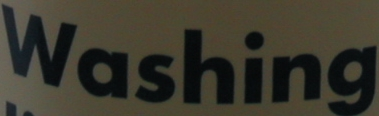

In [29]:
Image(testimage)

In [30]:
test_data_single_image_Prediction(model,testimage)

1/1 [==============================] - 0s 56ms/step
Predicted Text in the Image:  WASHING
Time Taken for Processing:  0:00:00.098033


In [ ]:
print(xyz)

In [32]:
test_data2=pd.read_csv('demo_data.csv') 

In [33]:
test_data2.drop(['Unnamed: 0'],axis=1,inplace=True)
print(test_data2.shape)

(26, 2)


In [34]:
test_data2.head()

,ImageName,Labels
0,demoaimages/img1.jpg,WHAT
1,demoaimages/33.jpg,MEMOREX
2,demoaimages/34.jpg,COMPACT
3,demoaimages/38.jpg,PROFESSIONAL
4,demoaimages/36.jpg,RECORDABLE


In [35]:
test_img_paths=test_data2['ImageName'].values
test_img_labels=test_data2['Labels'].values
total=26

In [36]:
test_data_multiple_image_Prediction(model,test_img_paths,test_img_labels,total)

1/1 [==============================] - 0s 100ms/step
--------------------------------------------------------------------------------
Actual Text:  WHAT    Predicted Text:  WHAT
1/1 [==============================] - 0s 79ms/step
--------------------------------------------------------------------------------
Actual Text:  MEMOREX    Predicted Text:  MEMOREX
1/1 [==============================] - 0s 84ms/step
--------------------------------------------------------------------------------
Actual Text:  COMPACT    Predicted Text:  COMPACT
1/1 [==============================] - 0s 57ms/step
--------------------------------------------------------------------------------
Actual Text:  PROFESSIONAL    Predicted Text:  PROFESSIONAL
1/1 [==============================] - 0s 65ms/step
--------------------------------------------------------------------------------
Actual Text:  RECORDABLE    Predicted Text:  RECORDABLE
1/1 [==============================] - 0s 50ms/step
----------------------